Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [31]:
NAME = "Tutorial 4  "
COLLABORATORS = "Aakash Rajpal"

---

# 5. Hidden Markov Models
**Acknowledgements:**  We would like to thank Ignacio Peis (http://www.tsc.uc3m.es/~ipeis/bio.html) for providing most of the content of this notebook

In [3]:
import numpy as np
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import nltk
from sklearn.model_selection import train_test_split
import pprint, time
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [4]:
from IPython.core.display import Image, display

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6,6]
plt.rcParams['font.size'] = 12


## HMMs in hmmlearn

[hmmlearn](https://hmmlearn.readthedocs.io/en/latest/api.html) is a python package that implements the HMM model and its principal applications of inference and learning, and follows scikit-learn API as close as possible, but adapted to sequence data. Its easy interface allows to create HMM models and optimize their parameters using the Baum-Welch algorithm in a few lines of code.

An example of the definition of a HMM, and sampling sequences from the model, is included below. For this model, observations $\textbf{x}_t$ are bidimensional, and we use $L=3$ states.

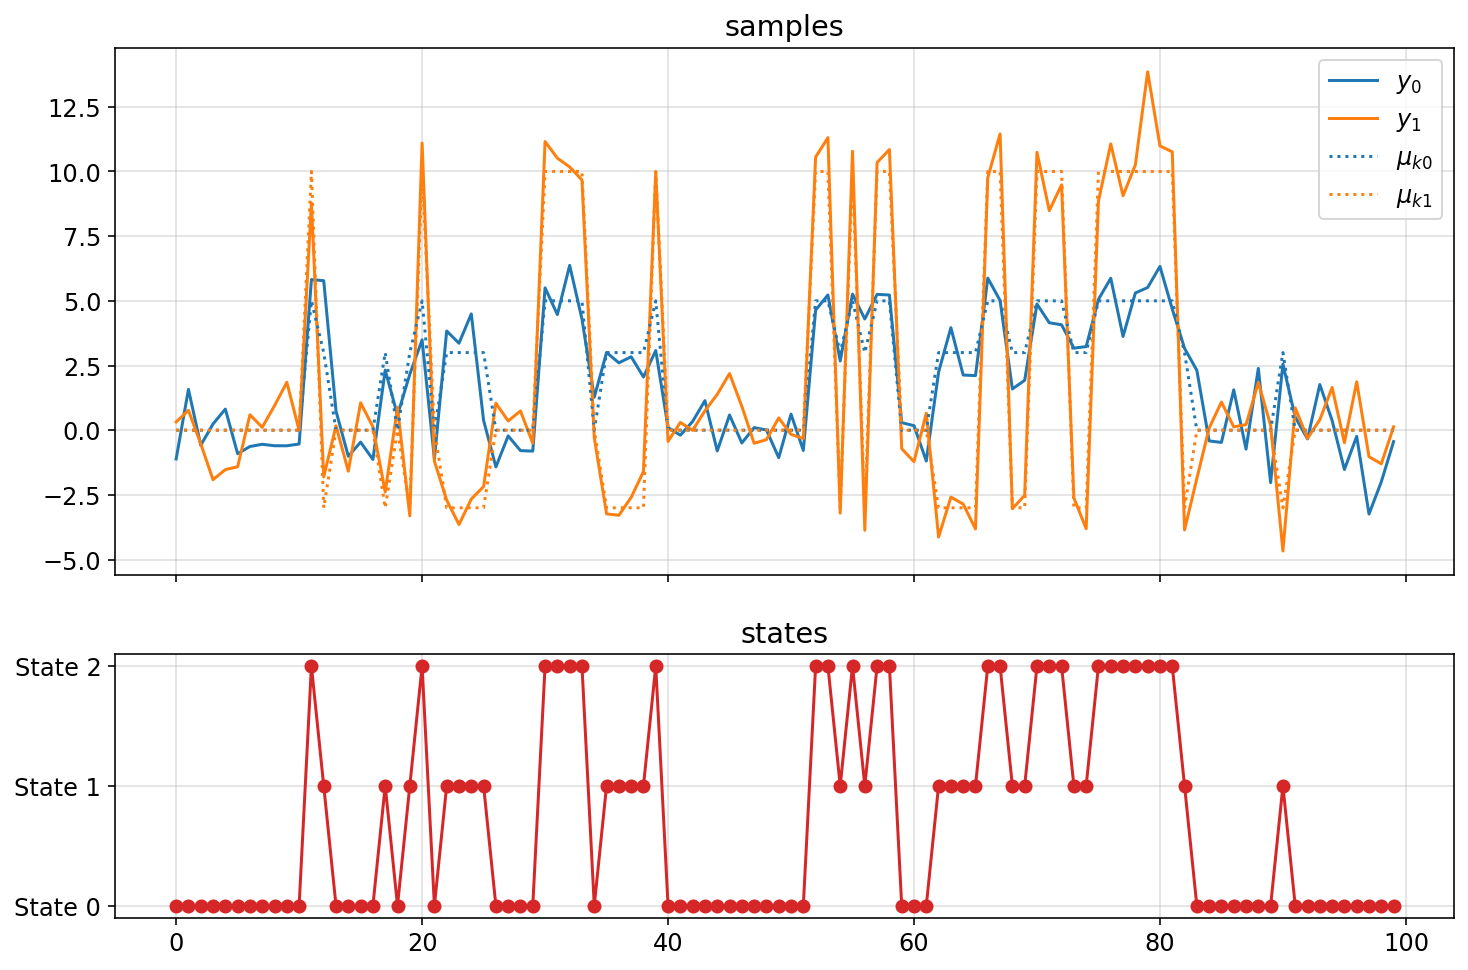

In [6]:
np.random.seed(42)

# Number of states
L=3

# Define the HMM model
model = hmm.GaussianHMM(n_components=L, covariance_type="full")

# SETTING THE PARAMETERS
# Prior probabilities Pi
Pi = np.array([0.6, 0.3, 0.1])
model.startprob_ = Pi

# Transition matrix A
A = np.array([[0.7, 0.2, 0.1],
              [0.3, 0.5, 0.2],
              [0.3, 0.3, 0.4]])
model.transmat_ = A

# Parameters of the state-condition Gaussian densities p(yt|st)
mus = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
Sigmas = np.tile(np.identity(2), (3, 1, 1))
model.means_ = mus
model.covars_ = Sigmas

# Obtain a sequence of 100 samples
Y, S = model.sample(100)

f, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(Y[:, 0], label=r'$y_0$')
ax[0].plot(Y[:, 1], label=r'$y_1$')
ax[0].plot(model.means_[S][:, 0], ':', color='tab:blue', label=r'$\mu_{k0}$')
ax[0].plot(model.means_[S][:, 1], ':', color='tab:orange', label=r'$\mu_{k1}$')
ax[0].grid(alpha=0.4)
ax[0].legend(loc='best')
ax[0].set_title('samples')
ax[1].plot(S, '-o', color='tab:red')
plt.yticks([0, 1, 2], ['State 0', 'State 1', 'State 2'])
ax[1].grid(alpha=0.4)
ax[1].set_title('states')
plt.show()

# Exercise 1: Part-Of-Speech (POS) Tagging with fully observed HMMs

&nbsp;

<img src='http://www.tsc.uc3m.es/~ipeis/ML2/POS.png' width=500 />

&nbsp;

In Natural Language Processing (NLP), associating each word in a sentence with a proper POS (part of speech) is known as POS tagging or POS annotation. POS tags are also known as word classes, morphological classes, or lexical tags. A HMM can be fitted to text data, using the states $S$ for modeling the tags. Hence, for this part, we will fit a **HMM with fully observed data**.

In this experiment, we will use a Multinomial HMM. Features are the appearance of each word in a vocabulary conformed by words from a big database of sentences. Hence, the emission parameters are a big matrix $\mathbf{B}$ with dimensions $L\times M$, where $L$ is the number of states (number of tags) and $M$ is the size of the vocabulary (number of different words in the database).

The dataset for this experiment is the Treebank database, that can be easily download from the [nltk package for NLP in python](https://www.nltk.org/). As the dataset is tagged, we do not have to perform the Baum-Welch algorithm, we can just  directly obtain the MLE of the model parameters. The dataset consist on a total of 3914 sentences, and each sentence $n$ is composed by $T_n$ words with their respective tags.


In [7]:
# nltk datasets will be downloaded in "Users/user/nltk_data".

#download the treebank corpus from nltk
nltk.download('treebank')

#download the universal tagset from nltk
nltk.download('universal_tagset')

# reading the Treebank tagged sentences
# data contains a list with sentences
# each sentence is a list of tuples with a word and the corresponding tag
data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print('Number of sentences: ' + str(len(data)))

#print each word with its respective tag for first two sentences
print('First two sentences:')
for sent in data[:2]:
    for tuple in sent:
        print(tuple)


[nltk_data] Downloading package treebank to
[nltk_data]     /home/adityadhall/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/adityadhall/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Number of sentences: 3914
First two sentences:
('Pierre', 'NOUN')
('Vinken', 'NOUN')
(',', '.')
('61', 'NUM')
('years', 'NOUN')
('old', 'ADJ')
(',', '.')
('will', 'VERB')
('join', 'VERB')
('the', 'DET')
('board', 'NOUN')
('as', 'ADP')
('a', 'DET')
('nonexecutive', 'ADJ')
('director', 'NOUN')
('Nov.', 'NOUN')
('29', 'NUM')
('.', '.')
('Mr.', 'NOUN')
('Vinken', 'NOUN')
('is', 'VERB')
('chairman', 'NOUN')
('of', 'ADP')
('Elsevier', 'NOUN')
('N.V.', 'NOUN')
(',', '.')
('the', 'DET')
('Dutch', 'NOUN')
('publishing', 'VERB')
('group', 'NOUN')
('.', '.')


We are going to split the dataset in a 80% of the sentences for training, and 20% for test. All the sentences in these subsets will be concatenated in <code>train_words</code> and <code>test_words</code>, respectively. We are going to build a vocabulary <code>vocab</code> that will contain every word in the train set. The variable <code>tags</code> will contain the $L$ possible tags, which will be out states.

In [8]:
# split data into training and validation set in the ratio 80:20
train_sentences,test_sentences =train_test_split(data,train_size=0.80,test_size=0.20,random_state = 101)

# join all the sentences in train and test sets
train_words = [ tup for sent in train_sentences for tup in sent ]
test_words = [ tup for sent in test_sentences for tup in sent ]
print('Train words: ' + str(len(train_words)))
print('Test words: ' + str(len(test_words)))

# check some of the tagged words.
print('\nFirst 20 training words: ')
print(train_words[:20])

# use set datatype to check how many unique tags are present in training data
tags = {tag for word,tag in train_words}
L = len(tags)
print('\nNumber of tags: ' + str(L))
print(tags)

# check total words in vocabulary
vocab = {word for word,tag in train_words}
print('\nNumber of words in the vocabulary: ' + str(len(vocab)))

Train words: 80310
Test words: 20366

First 20 training words: 
[('Drink', 'NOUN'), ('Carrier', 'NOUN'), ('Competes', 'VERB'), ('With', 'ADP'), ('Cartons', 'NOUN'), ('At', 'ADP'), ('last', 'ADJ'), ('count', 'NOUN'), (',', '.'), ('Candela', 'NOUN'), ('had', 'VERB'), ('sold', 'VERB'), ('$', '.'), ('4', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('its', 'PRON'), ('medical', 'ADJ'), ('devices', 'NOUN')]

Number of tags: 12
{'ADV', '.', 'X', 'PRON', 'VERB', 'NOUN', 'CONJ', 'ADJ', 'DET', 'PRT', 'NUM', 'ADP'}

Number of words in the vocabulary: 11052


**1.1 Build the functions for obtaining the emission and transition probabilities**

In [9]:

def emission(word, tag, train_bag):
    """Probability B_im that a tag i emits a word m, computed from train_bag"""
    # 1 Count the number of times the given word appears in the training set with the given tag, N_im
    # 2 Count the number of words with the given tag in the training set, N_i
    # B_im = N_im / N_i
    # YOUR CODE HERE
    N_im = 0
    N_i = 0
    for (w, t) in train_bag:
        if word == w and tag == t:
            N_im += 1
        if tag == t:
            N_i += 1
    B_im = N_im / N_i
    return B_im

def transition(tag1, tag2, train_bag):
    """Probability A_ij of state j (tag2) given that previous state was i (tag1)"""
    # 1 Obtain the tag sequence from training set
    # 2 Count the number of times tag 1 occurs, N_i
    # 3 Count the number of times tag_2 occurs after tag_1, N_ij
    # A_ij = N_ij / N_i
    # YOUR CODE HERE
    N_i = 0
    N_ij = 0
    flag = 0
    for (w,t) in train_bag:
        if t == tag2 and flag == 1:
            N_ij += 1
        flag = 0
        if t == tag1:
            N_i += 1
            flag = 1
    p = N_ij / N_i
    return p

def transition_matrix(tags, train_bag):
    """ Build transition matrix A of dimensions LxL from train_bag"""
    # A_ij is the transition probability from tag i to tag j
    # YOUR CODE HERE
    A = np.zeros((len(tags), len(tags)))
    for i, tag1 in enumerate(tags):
        for j, tag2 in enumerate(tags):
            A[i][j] = transition(tag1, tag2, train_bag)
    return A


In [10]:
def Viterbi(words, transition_matrix, train_bag):
    """ Obtain the most probable sequence of tags given a list of words"""
    state = []
    T = list(set([pair[1] for pair in train_bag]))

    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = transition_matrix.loc['.', tag]
            else:
                transition_p = transition_matrix.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = emission(words[key], tag, train_bag)
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)

    return list(zip(words, state))

**1.1.a. Plot the estimated transition matrix using the trianing sentences. Which is the most probably transition from the ADJ state? And from the DET? Do they make sense?**

From the ADJ tag next most probable tag is Noun. From the DET tag also next most probable tag is NOUN. They make sense as both DET or Determiners and ADJ or Adjectives are the words which modify or specify the properties of noun.

,ADV,.,X,PRON,VERB,NOUN,CONJ,ADJ,DET,PRT,NUM,ADP
ADV,0.081458,0.139255,0.022886,0.012025,0.339022,0.032196,0.006982,0.130721,0.071373,0.014740,0.029868,0.119472
.,0.052569,0.092372,0.025641,0.068769,0.089690,0.218539,0.060079,0.046132,0.172192,0.002789,0.078210,0.092908
X,0.025754,0.160869,0.075726,0.054200,0.206419,0.061695,0.010379,0.017682,0.056890,0.185086,0.003075,0.142226
PRON,0.036902,0.041913,0.088383,0.006834,0.484738,0.212756,0.005011,0.070615,0.009567,0.014123,0.006834,0.022323
VERB,0.083886,0.034807,0.215930,0.035543,0.167956,0.110589,0.005433,0.066390,0.133610,0.030663,0.022836,0.092357
NOUN,0.016895,0.240094,0.028825,0.004659,0.149134,0.262344,0.042454,0.012584,0.013106,0.043935,0.009144,0.176827
CONJ,0.057080,0.035126,0.009330,0.060373,0.150384,0.349067,0.000549,0.113611,0.123491,0.004391,0.040615,0.055982
ADJ,0.005243,0.066019,0.020971,0.000194,0.011456,0.696893,0.016893,0.063301,0.005243,0.011456,0.021748,0.080583
DET,0.012074,0.017393,0.045134,0.003306,0.040247,0.635906,0.000431,0.206411,0.006037,0.000287,0.022855,0.009918
PRT,0.009393,0.045010,0.012133,0.017613,0.401174,0.250489,0.002348,0.082975,0.101370,0.001174,0.056751,0.019569


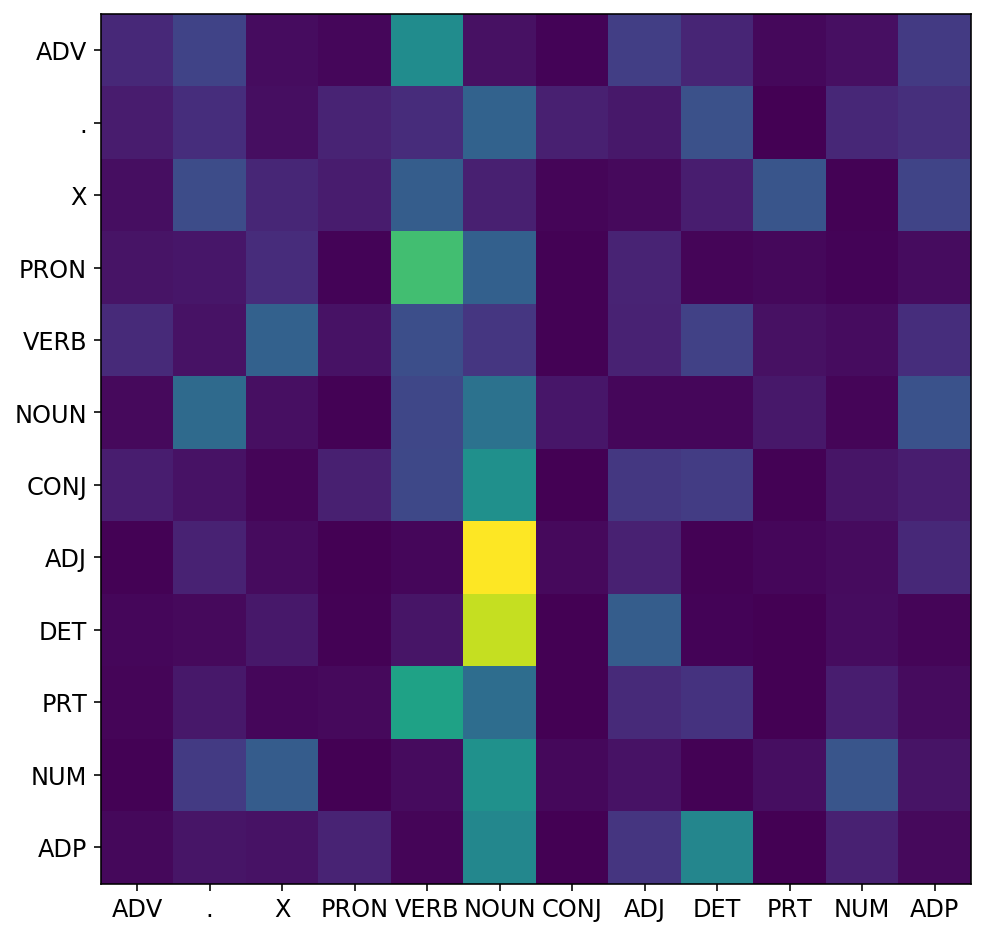

In [11]:
# convert the matrix to a df for better readability
#the table is same as the transition table shown in section 3 of article
np.random.seed(1)
A = transition_matrix(tags,train_bag=train_words)
A = pd.DataFrame(A, columns = list(tags), index=list(tags))
plt.figure(figsize=(8, 8))
plt.imshow(A)
plt.xticks(np.arange(len(tags)), list(tags))
plt.yticks(np.arange(len(tags)), list(tags))
display(A)

**1.2. Choosing 10 random sequences from the test set, use the Viterbi function to estimate their tags. Compute the accuracy as the proportion of corrected tagged words.**

In [12]:
def compute_accuracy(test_sentences, train_words, transition_matrix, n_sentences=10, seed=1234):
    # YOUR CODE HERE
    random.seed(seed)
    indexes = random.sample(range(0, len(test_sentences)), n_sentences)
    total_tags = 0
    correct_tags = 0
    for i in indexes:
        words = [w for w,t in test_sentences[i]]
        tags = [t for w,t in test_sentences[i]]
        res = Viterbi(words, transition_matrix, train_words)
        total_tags += len(tags)
        pred_tags = [t for w,t in res]
        for count in range(len(tags)):
            if tags[count] == pred_tags[count]:
                correct_tags += 1
        
    accuracy = correct_tags / total_tags
    return accuracy
    

In [13]:

# accuracy
accuracy = compute_accuracy(test_sentences, train_words, transition_matrix=A, n_sentences=10, seed=1234)
print('Viterbi Algorithm Accuracy: ',accuracy*100)

Viterbi Algorithm Accuracy:  87.97250859106529


**1.3. Obtain the emission matrix $\mathbf{B}$ matrix for the first 200 words in the vocabulary using the emission function. You should calculate the probability of each word in <code>vocab</code> for each tag.**

*Note: The computation of $\mathbf{B}$ for all the words in the vocabulary might take a while (up to half an hour).*

In [19]:

def estimate_B(tags, train_words, vocab, n_words):
    # YOUR CODE HERE
    vocab_list = list(vocab)
    tag_list = list(tags)
    B = np.zeros((n_words, len(tags)))
    for i, w in enumerate(vocab_list):
        for j,t in enumerate(tag_list):
            B[i][j] = emission(w, t, train_words)
        if i == n_words - 1:
            break     
    return B

In [20]:
start = time.time()
B = estimate_B(tags, train_words, vocab, n_words=200)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)


Time taken in seconds:  10.480677366256714


In [23]:
vocab_list = list(vocab)
for i,t in enumerate(tags):
    word = vocab_list[np.argmax(B[:,i])]
    print("Tag : " + t + " Word : " + word)

Tag : ADV Word : well
Tag : . Word : CEO
Tag : X Word : *U*
Tag : PRON Word : my
Tag : VERB Word : said
Tag : NOUN Word : Mr.
Tag : CONJ Word : CEO
Tag : ADJ Word : high
Tag : DET Word : CEO
Tag : PRT Word : CEO
Tag : NUM Word : 3
Tag : ADP Word : OF


**1.3.a. Which is the most probable word in each tag? Do they  make sense?**

Above are the most probable words for each tag. Some of them make sense like verb, pronoun, adjective, num etc but some don't like CONJ.

**1.4. Compute the parameters $\boldsymbol{\pi}$ as the proportion of the tags in the train set.**

In [35]:

def estimate_pi(tags, train_words):
    pi = np.zeros((len(tags)))
    tag_data = [t for w,t in train_words]
    for i,t in enumerate(tags):
        for tag in tag_data:
            if tag == t:
                pi[i] += 1
    pi = pi / len(tag_data)
    return pi


In [36]:
pi = estimate_pi(tags, train_words)
print(pi)

[0.03487735 0.02733159 0.03181422 0.06412651 0.135226   0.28596688
 0.09839372 0.03210061 0.08662682 0.06478645 0.11606276 0.02268709]


**1.5. Can the proposed model caputre the semantic content? Why?**



It will be difficult to capture the semantics of the sentence as model focusses on relative positioning of the parts of speech in a sentence. But it might be possible that word predicted for a particular tag won't fit semantically with its surrounding words. Or to say its very unlikely that the sentence generated will be semantically correct.

**1.6. Can the proposed model caputre  the grammatical structure? Why?**


Yes the model can capture the grammatical structure as that is what the POS denotes. As when we model the hidden state as POS model learns the grammatical constraints between different parts of speech, like placement of adjective relative to the noun. As we also observed earlier that adj is most probably followed by a noun. 

## Exercise 2: Human Activity Recognition (HAR)

In Human Activity Recognition, the states $z_t$ can be used to represent activities or gestures and the observations $\mathbf{x}_t$ to features extracted from video or sensors signals. Each activity defines a distribution for the inertial sensors. The signals of an accelerometer will change depending on whether the patient is lying or running, for example.

The [DaLiAc (Daily Life Activities) database](https://www.mad.tf.fau.de/research/activitynet/daliac-daily-life-activities/) consists of data from 19 subjects (8 female and 11 male, age 26 ± 8 years, height 177 ± 11 cm, weight 75.2 ± 14.2 kg, mean ± standard deviation (SD)) that performed 13 daily life activities. For this exercise, we only consider 1 subject.

Four sensors were used for data acquisition placed on the left ankle, the right hip, the chest, and the right ankle. Each sensor node was equipped with a triaxial accelerometer and a triaxial gyroscope. Data were sampled with 204.8 Hz Hz and were stored on SD card.

In [26]:
data = pd.read_csv('HAR_data.csv', index_col=0)
activities = ['Sitting', 'Lying', 'Standing', 'Washing Dishes', 'Vacuuming', 'Sweeping', 'Walking',
              'Ascending stairs', 'Descending stairs', 'Treadmill running', 
             'Bicycling on ergometer (50W)', 'Bicycling on ergometer (100W)', 'Rope jumping']
labels = data.iloc[:, -1].values
print(data.shape)
data["Activity"].replace({"Bicycling on ergometer (100W)Rope jumping": "Bicycling on ergometer (100W)", 
                       "13": "Rope jumping"}, inplace=True)
data.head()
L = len(activities)

(245576, 26)


In [40]:
data.shape

(245576, 26)

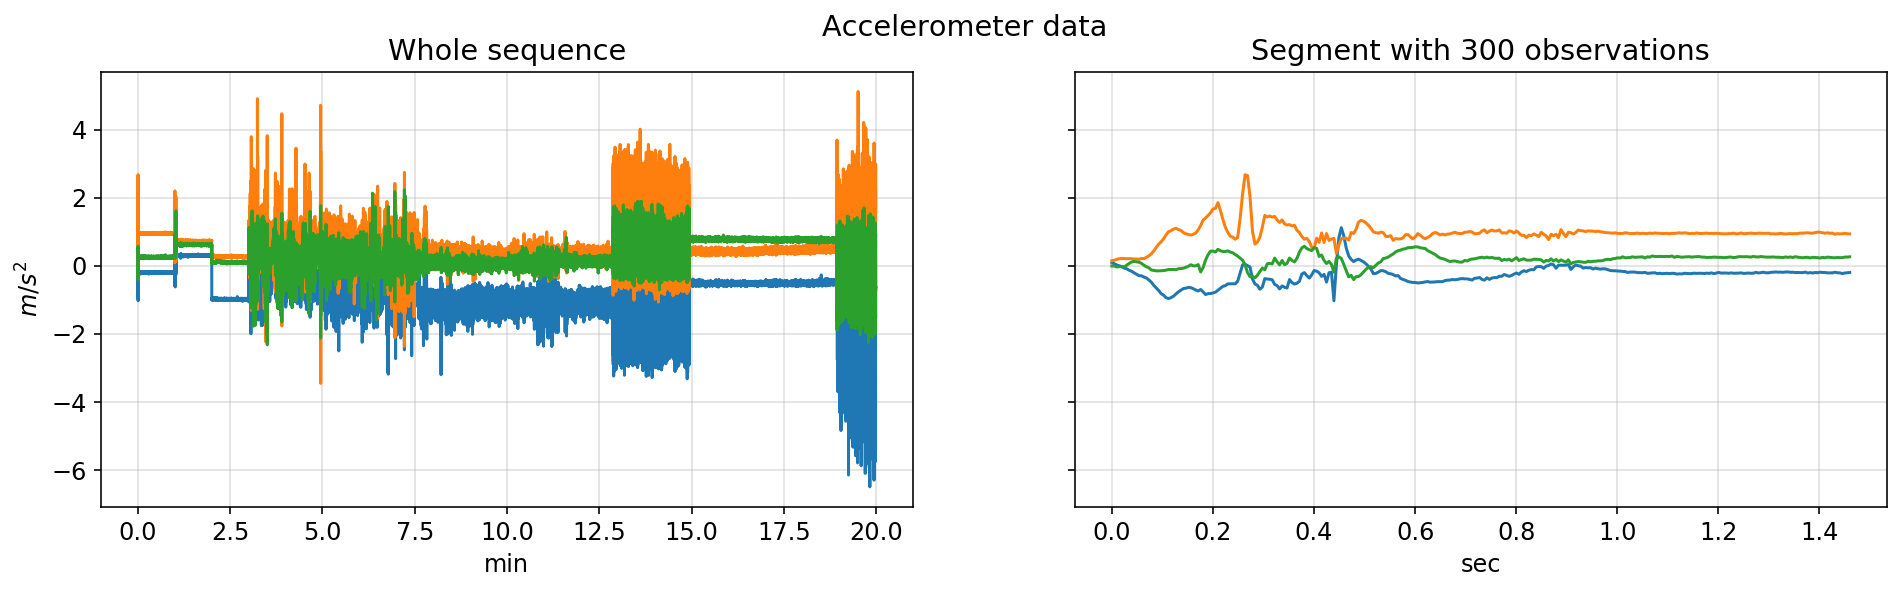

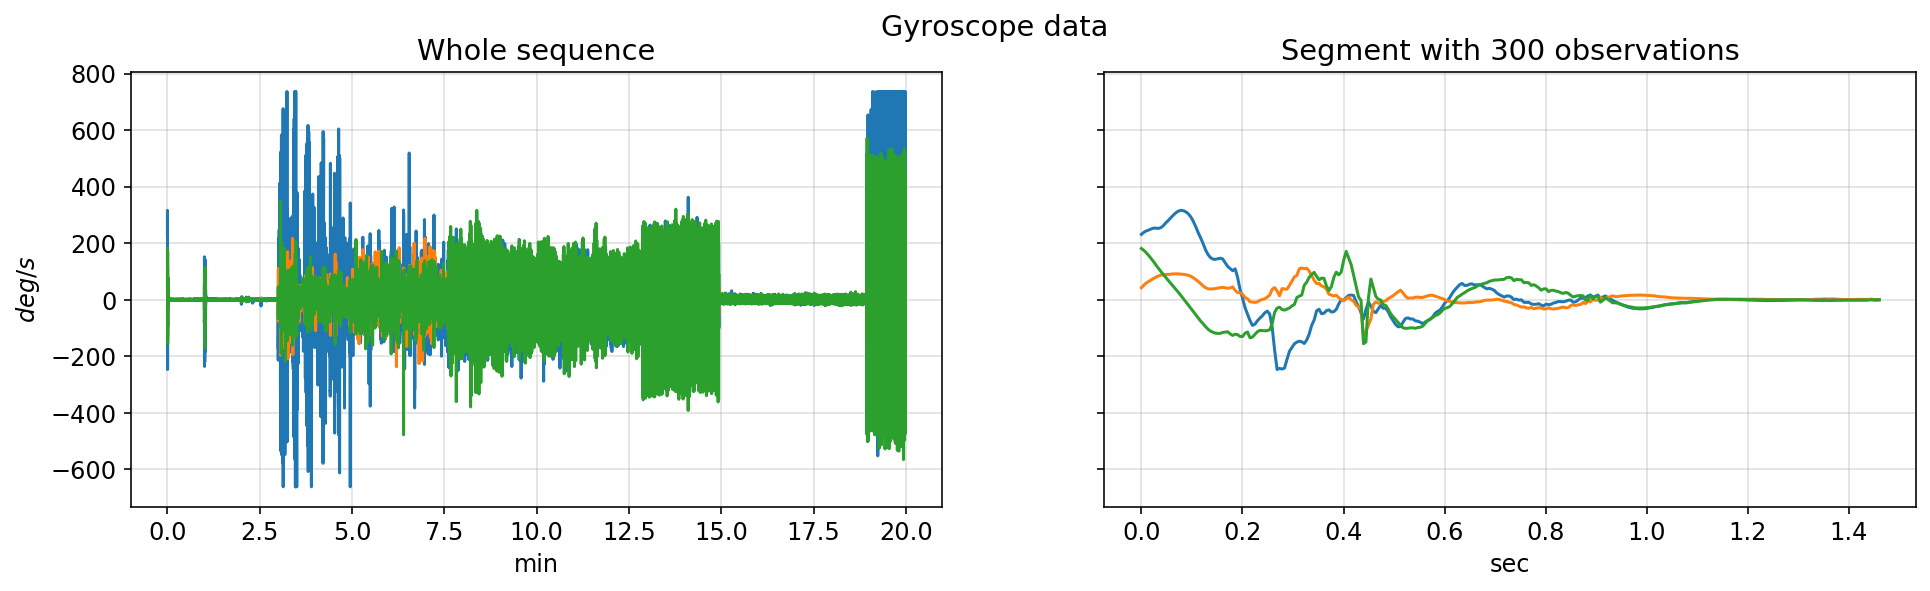

In [27]:
fs = 204.8
f, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)
t = np.arange(data.shape[0])/fs / 60

accelerometer_data = data.iloc[:, 0:3]
ax[0].plot(t, accelerometer_data)
ax[0].set_xlabel('min')
ax[0].grid(alpha=0.4)
ax[0].set_title('Whole sequence')
ax[0].set_ylabel(r'$m/s^2$')

ax[1].plot(t[:300]*60,accelerometer_data.iloc[:300, :])
ax[1].set_xlabel('sec')
ax[1].grid(alpha=0.4)
ax[1].set_title('Segment with 300 observations')

plt.suptitle('Accelerometer data')


gyroscope_data = data.iloc[:, 3:6]
f, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)

ax[0].plot(np.arange(data.shape[0])/fs / 60, gyroscope_data)
ax[0].set_xlabel('min')
ax[0].grid(alpha=0.4)
ax[0].set_title('Whole sequence')
ax[0].set_ylabel(r'$deg/s$')

ax[1].plot(t[:300]*60, gyroscope_data.iloc[:300, :])
ax[1].set_xlabel('sec')
ax[1].grid(alpha=0.4)
ax[1].set_title('Segment with 300 observations')

plt.suptitle('Gyroscope data')

plt.show()

#### Data Preprocessing

The sampling frequency is $f_s=204.8 Hz$. As it has no sense to guess the performed activity each $1/f_s=4.8 ms$, in HAR, segmentation of the data is performed using windows of $W$ samples. Thus, a segment of 5 seconds correspond to a window of 1024 samples. For each window, we extract the mean and standard deviation as features.

(240, 48)


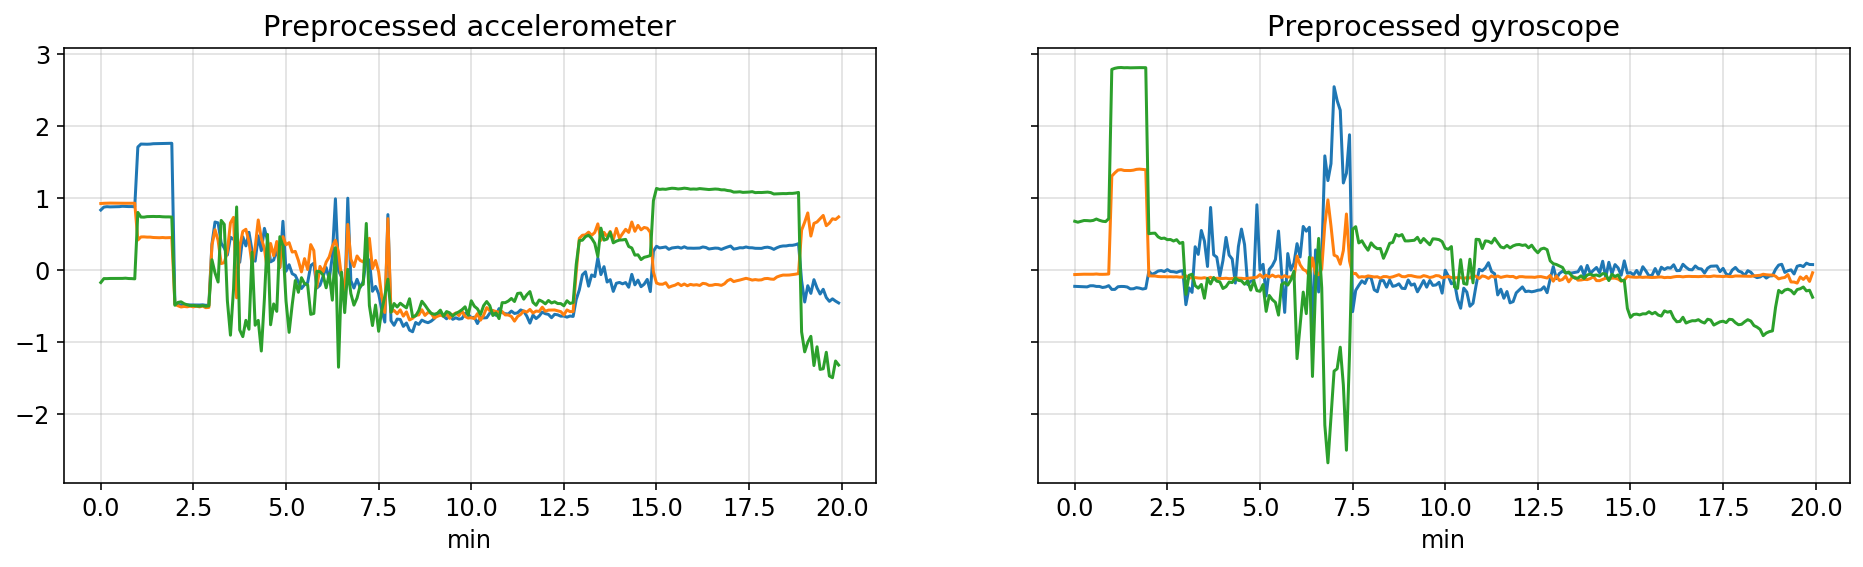

In [28]:
# Normalize data
data_n = data.iloc[:, :-2]
scaler = StandardScaler().fit(data_n)
data_n = scaler.transform(data_n)


fs = 204.8  # 204.8 Hz
Twind = 5 # 5 seconds
Wwind = int(fs * Twind)
nsegments = np.ceil(len(data_n) / Wwind).astype(int)

X = []
acts = []
for s in range(nsegments):
    # Extract features for each segment
    segment = data_n[s*Wwind:(s+1)*Wwind, :]
    mean = np.mean(segment, axis=0)
    std = np.std(segment, axis=0)
    feat = np.concatenate((mean, std))
    X.append(feat)
    
    # Labels
    l = labels[s*Wwind:(s+1)*Wwind]
    counts = np.unique(l, return_counts=True)
    label = counts[0][np.argmax(counts[1])]
    acts.append(label)

X = np.stack(X)
acts = np.stack(acts) # range 0:K-1

print(X.shape)

f, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)
t = np.arange(X.shape[0])*Wwind/fs / 60

ax[0].plot(t, X[:, :3])
ax[0].set_xlabel('min')
ax[0].grid(alpha=0.4)
ax[0].set_title('Preprocessed accelerometer')

ax[1].plot(t, X[:, 6:9])
ax[1].set_xlabel('min')
ax[1].grid(alpha=0.4)
ax[1].set_title('Preprocessed gyroscope');

**2.1. Using hmmlearn, create a Gaussian HMM model and fit it to the preprocessed data stored in $X$ from the DaLiAc database. Using plt.imshow(), show the transition matrix $A$ as an image, in order to visualize better its elements. Use plt.xticks and plt.yticks to include the activities as labels.**

In [29]:
def fit_with_GaussianHMM(X,n_components, covariance_type="diag"):
    # YOUR CODE HERE
    model = hmm.GaussianHMM(n_components, covariance_type, n_iter=1000)
    model.fit(X)
    transition_matrix = model.transmat_
    return model, transition_matrix


Text(0.5, 1.0, 'Transition Matrix')

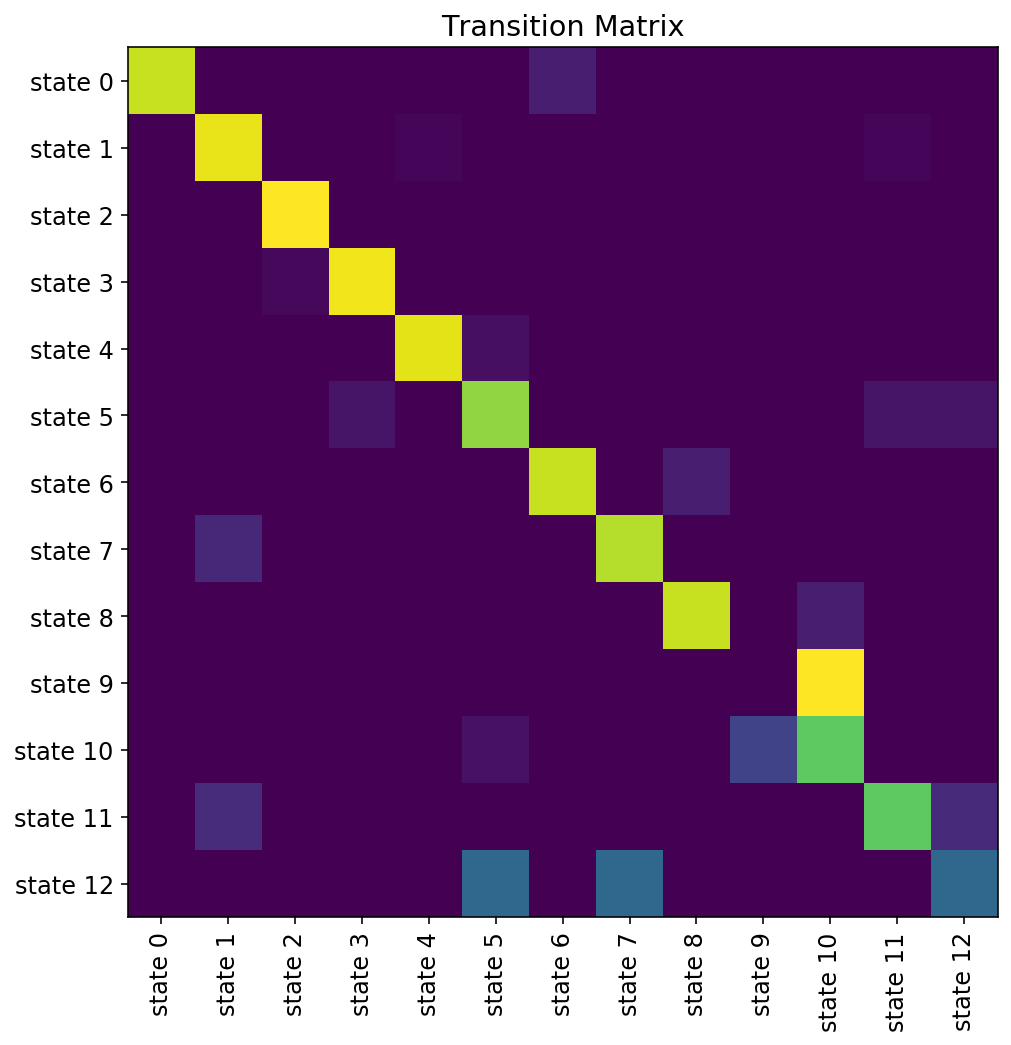

In [30]:
# Plot the parameters of the model


np.random.seed(123)


model, transition_matrix = fit_with_GaussianHMM(X, n_components=L)
plt.figure(figsize=(8, 8))
plt.imshow(transition_matrix)
plt.xticks(np.arange(L), ['state '+str(i) for i in range(L)], rotation=90)
plt.yticks(np.arange(L), ['state '+str(i) for i in range(L)]);
plt.title('Transition Matrix')

**2.1.a. Decribe the transition matrix you have obtained, and provide with your intuitions about it.**


Transition matrix shows that the diagonal elements have the highest probability only false for the case where transition takes place from state 9 to 10. As these states correspond to activities one could understand that actions performed do not change easily across time. But still if we consider a complex action comprising of sequence of actions taking place then we can find some substantial transition probabilities.

**2.1.b. Is there any state for which the probability of transitioning to other state considerable?**

from state 9 to 10.

**2.1.c. Run the algorithm multiple times. Do you get the same transition matrix? Why (not)?**

It comes to be the same as the as way we compute these transition probabilities is deterministics and does not depend on the iterations of the model fitting.

**2.2. Use the corresponding method of hmmlearn to run the Viterbi algorithm that gives you the most probable sequence of states given the signal $X$. Compute the MAP estimate of the states  and use it to plot the transition matrix using the activity labels.**

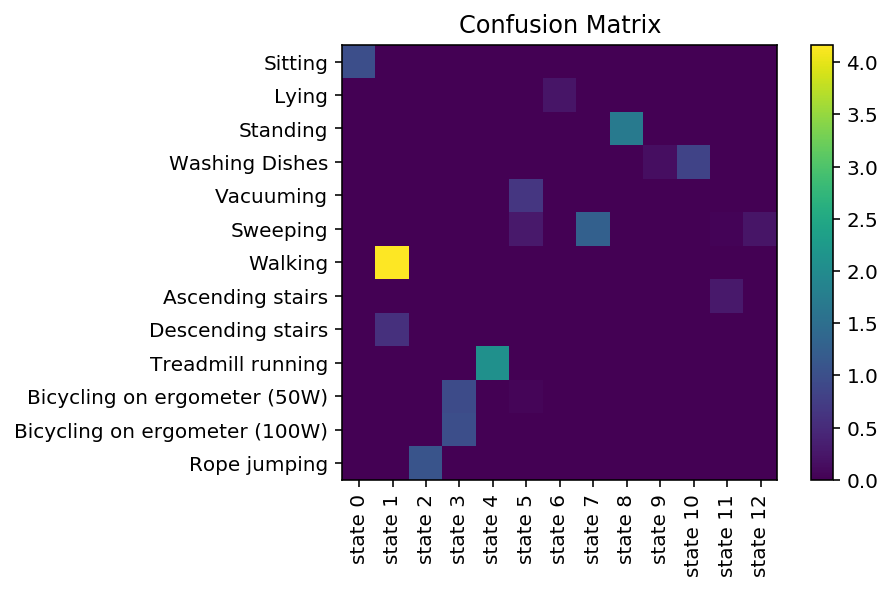

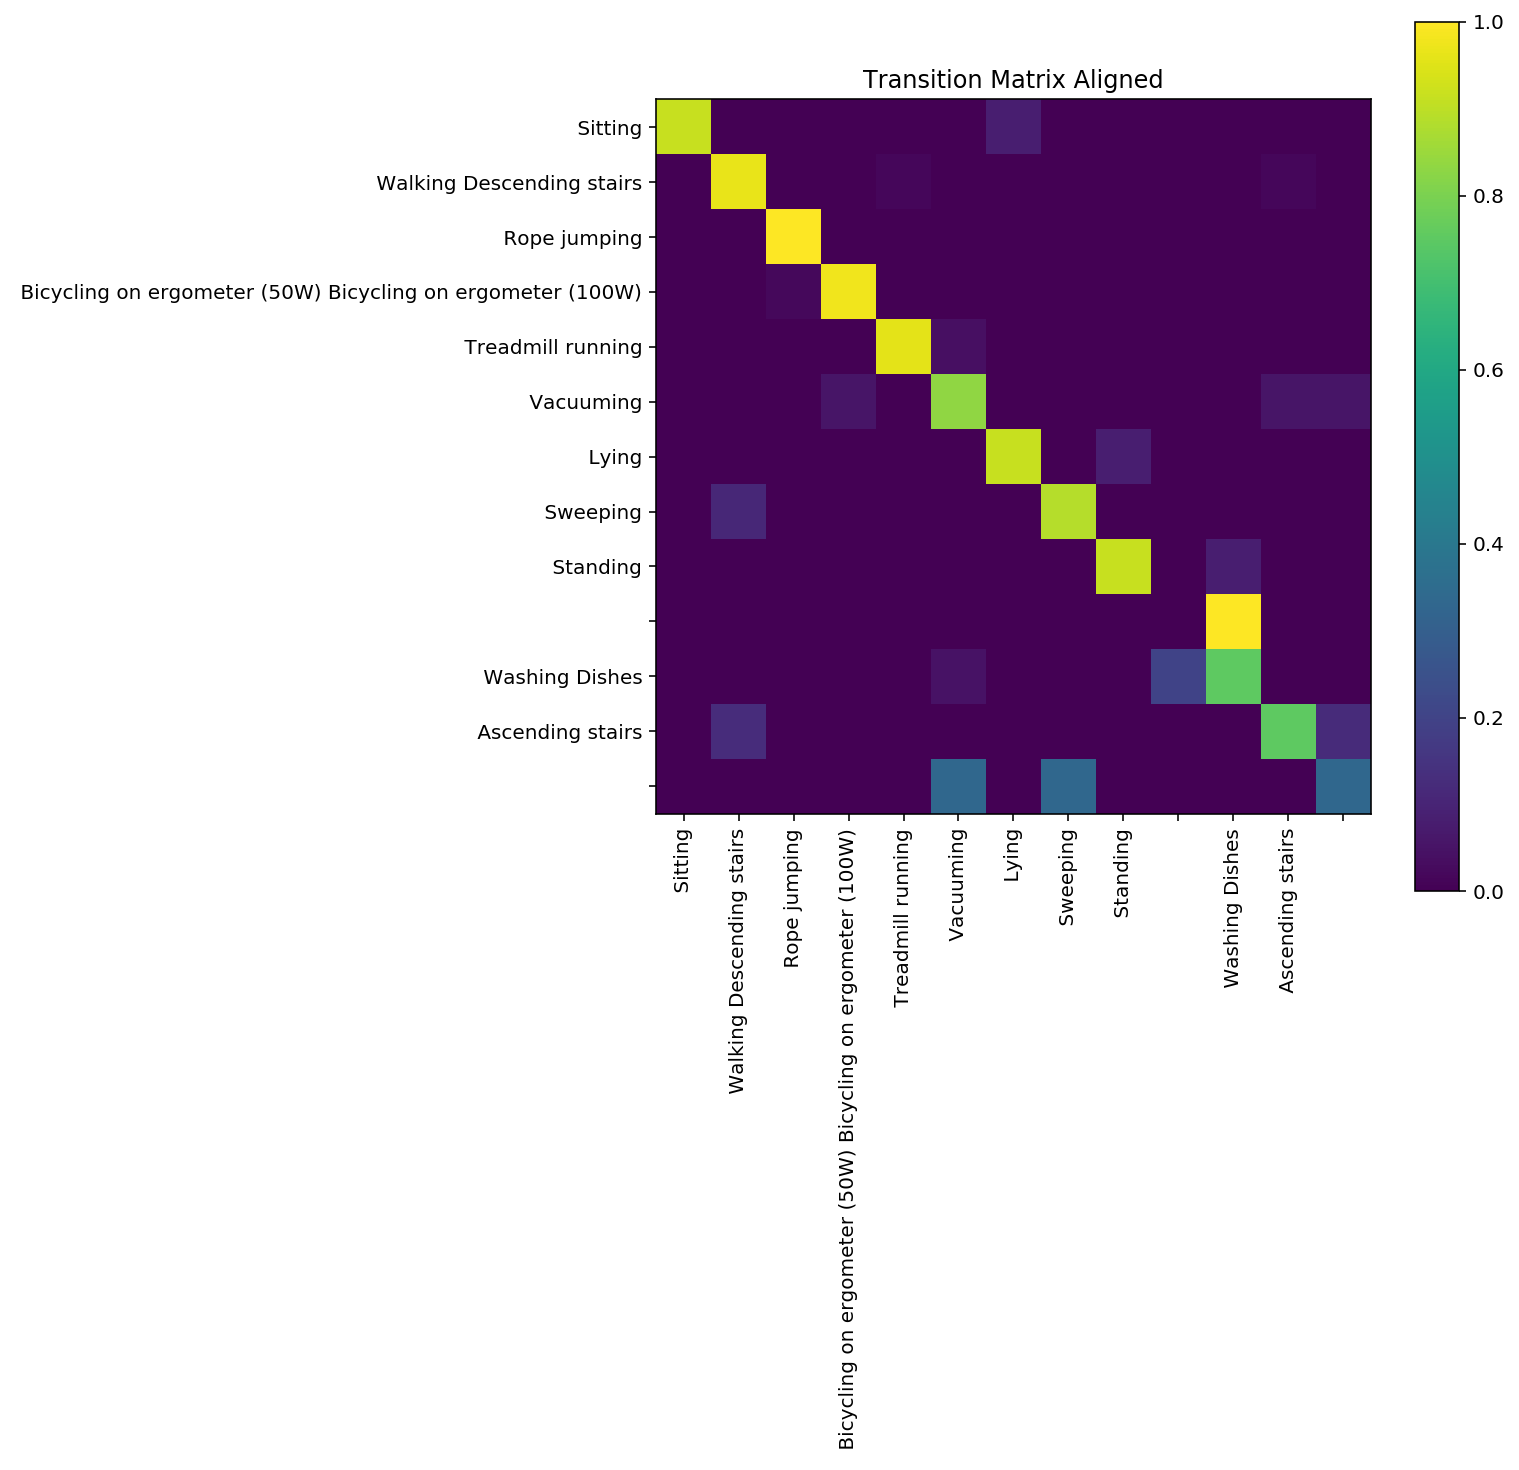

In [45]:

def align_states(activities, states):
    """Align each hidden state with its corresponding class."""
    
    # M_ci show how many points of class c has been associated to state i
    M = confusion_matrix(activities, states)
    align = np.argmax(M, axis=0)
    aligned_states = states.copy()
    for s in range(13):
        aligned_states[states==s] = align[s]
    return aligned_states, M


states = model.predict(X)
aligned_states, M = align_states(acts, states)

M_norm = M/M.sum(1)
plt.figure()
plt.imshow(M_norm)
plt.xticks(np.arange(L), ['state '+str(i) for i in range(L)], rotation=90)
plt.yticks(np.arange(L), activities)
plt.title('Confusion Matrix')
    
plt.colorbar()
    
transition_matrix = model.transmat_

align = np.argmax(M, axis=1)

activities_aligned =['' for s in align ]
for i, s in enumerate(align):
    activities_aligned[s] += ' ' + activities[i]


    
plt.figure(figsize=(8, 8))
plt.imshow(transition_matrix)
plt.xticks(np.arange(L), activities_aligned, rotation=90)
plt.yticks(np.arange(L), activities_aligned);
plt.title('Transition Matrix Aligned')
plt.colorbar()


**2.2.a. Why does the state index  not coincide with the class index?**

As it can be observed from the confusion matrix for certain activities the state with max score coincide, hence the state index and the class index does not coincide.

**2.1.b. Is there any activity for which the probability of transitioning to another one is considerable? If so, does it make sense?**

Not considerable but in case of Standing there is < 0.2 probablilty to washing dishes which actually makes sense. Similar cases are there where sitting is followed by lying; sweepig is followed by walking.

**2.1.c. Do we really need all the states? Why (not)?**

We do need them as though they are not mapped to any activity but still they matter as they are in between the sequence of staes and as here we consider first order assumption we can 't ommit the states as it is parent for its subsequent state.

## References

[1]. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

[2]. Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

